In [1]:
#%matplotlib nbagg
#Import required libraries
# from serial import Serial
import csv
import time
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import os
# from drawnow import drawnow, figure
from scipy import stats
from scipy.signal import butter, lfilter, freqz, filtfilt, medfilt, resample
from scipy.fft import fft, fftfreq
from sklearn.metrics import mean_squared_error
import pandas as pd
import math
from matplotlib import rcParams
import copy
# rcParams.update({'figure.autolayout': True})

In [2]:
def butter_filter(data, cutoff, order, fs):
#     nyq = 0.5 * fs
#     normal_cutoff = cutoff / nyq
    normal_cutoff = cutoff
    b, a = butter(order, normal_cutoff)  # , btype='low', analog=False
#     b, a = butter(3, 0.1)
    y = filtfilt(b, a, data)
    return y

def get_rolling_slope(csv_data, datapnt_delay, calibration_factor):
    window_width_raw = 30
    window_width_flowrate = 10
    cutoff_1 = 0.05 # 0.02
    order_1 = 3 # 12
    fps = 1000/datapnt_delay

 
    raw_data = []
    flow_rate = []
    flow_rate_filtered = []

    for i in range(len(csv_data)):
        val = csv_data[i]
        raw_data.append(val)
        if i>window_width_raw*fps:
            curr_window_raw = raw_data[int(-window_width_raw*fps):]
#             curr_window_raw_filtered = butter_filter(curr_window_raw, cutoff_1, order_1, fps)
            curr_window_raw_filtered = curr_window_raw
            x =list(range(len(curr_window_raw_filtered)))
            curr_slope, intercept, r, p, std_err = stats.linregress(x, curr_window_raw_filtered)
             
            #Convert light results
            syringe_rad = 21.7/2 #Syringe radius in mm
            syringe_area = math.pi*(syringe_rad ** 2)
            density = 1 #1g/mL
            curr_flowrate = (1/density)*curr_slope*60*fps*-1  #convert from g/s to mL/min
            
            flow_rate.append(curr_flowrate)
        else:
            flow_rate.append(0)
                
        cutoff_2 = 0.6
        order_2 = 6
        if len(flow_rate) > (window_width_raw+window_width_flowrate)*fps:
            curr_start = int(-window_width_flowrate*fps)
            curr_window_flowrate = flow_rate[curr_start:]
            
#             curr_window_flowrate_filtered = butter_filter(curr_window_flowrate, cutoff_2, order_2, fps)[0]
            curr_window_flowrate_filtered = stats.trim_mean(curr_window_flowrate,0.3)
            
#             calibration_factor = 1.2  #0.54
            curr_window_flowrate_filtered = calibration_factor * curr_window_flowrate_filtered
            flow_rate_filtered.append(curr_window_flowrate_filtered)
        
        else:
            flow_rate_filtered.append(0)
            
    
    return flow_rate_filtered, flow_rate  # returning flow_rate is just for testing
    #return flow_rate

def get_rolling_slope_measured(csv_data,time):
    #Sampled every 5 seconds - real data
    fps = 1
    window_width = 15
    slope = []
    raw_data = []
    for i in range(len(csv_data)):
        val = csv_data[i]
        raw_data.append(val)
        if i>window_width*fps:
            curr_window = raw_data[int(-window_width*fps):]
            x =list(range(len(curr_window)))
            curr_slope, intercept, r, p, std_err = stats.linregress(x, curr_window)
            slope.append(curr_slope)
        else:
            slope.append(0)
         
    #Calculate flow rate depending on sensor data type
    density_milk = 1 
    conversion_factor = 60
    time_interval = 5 #5s between data recordings
    flow_rate = np.multiply(slope,(1/time_interval*(1/density_milk)*conversion_factor))
    
    data_mean, data_std = np.mean(flow_rate), np.std(flow_rate)
    # identify outliers
    cut_off = data_std * 0.6
    lower, upper = data_mean - cut_off, data_mean + cut_off
    indexes_to_remove = np.where((flow_rate< lower) | (flow_rate > upper))[0]
  
    flow_rate_filtered = np.delete(flow_rate, indexes_to_remove)#indexes_to_remove[0])
    time_filtered = np.delete(np.array(time),indexes_to_remove)
        
    return flow_rate_filtered,time_filtered



def get_time(csv_data, datapnt_delay):
    fps = 1000/datapnt_delay
    time = np.multiply(range(0,len(csv_data)),(1/fps))
    return time


def process_csv(csv_path):
    file = open(csv_path)
    csvreader = csv.reader(file)
    csv_data = np.asarray(list(csvreader))
    csv_data = np.asfarray(csv_data,float).flatten()
    return csv_data

# # for processed data in 1 file
# def process_csv(csv_data):
# #     file = open(csv_path)
# #     csvreader = csv.reader(file)
# #     csv_data = np.asarray(list(csvreader))
#     csv_data = np.asfarray(csv_data,float).flatten()
#     return csv_data


In [47]:
# Path to folder containing sensor data (csv file format)
#csv_data_folder = r'C:\Users\a_hop\repos\fydp-neofeed\sensor_data\raspberrypi_data'
#csv_data_folder = r'C:\Users\anne\Projects\FYDP\fydp-neofeed\sensor_data\raspberrypi_data'
#sensor_csv_folder = r'C:\Users\a_hop\repos\fydp-neofeed\signal_processing\For Sensor Analysis\2022-03-24 - Processing Unfiltered Data'
sensor_csv_folder = r'C:\Users\a_hop\repos\fydp-neofeed\signal_processing\For Sensor Analysis\2022-03-24 - Processing Unfiltered Data'

#Read sensor data
# csv_name_30_light1 = r'total_avg_weights--2022-03-14 19-25-36.764243.csv'
# csv_name_30_light2 = r'total_avg_weights--2022-03-14 19-53-26.589013.csv'  # March 14 trial 2


#low trials
#csv_name_30_light1 = r'total_avg_weights--2022-03-23 20-46-21.145784.csv_low_PROCESSED.csv'  # March 24 trial 1
#csv_name_30_light2 = r'total_avg_weights--2022-03-23 21-17-11.310781.csv_low_PROCESSED.csv'  # March 24 trial 2
#csv_name_30_light3 = r'total_avg_weights--2022-03-23 22-47-43.773810.csv_low_PROCESSED.csv'  # March 24 trial 3

# high trials
csv_name_30_light1 = r'total_avg_weights--2022-03-23 21-40-13.264268.csv_high_PROCESSED.csv'  # March 24 trial 1
csv_name_30_light2 = r'total_avg_weights--2022-03-23 21-59-10.149583.csv_high_PROCESSED.csv'  # March 24 trial 2
csv_name_30_light3 = r'total_avg_weights--2022-03-23 22-18-40.139782.csv_high_PROCESSED.csv'  # March 24 trial 3


datapnt_delay = 90  # 899

csv_path_30_light1 = os.path.join(sensor_csv_folder, csv_name_30_light1)
csv_path_30_light2 = os.path.join(sensor_csv_folder, csv_name_30_light2)
csv_path_30_light3 = os.path.join(sensor_csv_folder, csv_name_30_light3)


csv_data_30_light1 = process_csv(csv_path_30_light1)  # [1000:12000]
csv_data_30_light2 = process_csv(csv_path_30_light2)  #[1000:17500]
csv_data_30_light3 = process_csv(csv_path_30_light3)


time_30_light1 = get_time(csv_data_30_light1, datapnt_delay)
time_30_light2 = get_time(csv_data_30_light2, datapnt_delay)
time_30_light3 = get_time(csv_data_30_light3, datapnt_delay)


# Load scale data
scale_csv_folder = r'C:\Users\a_hop\repos\fydp-neofeed\sensor_data\raspberrypi_data'
csv_name_30_light_measured = r'2022-03-24 - Unfiltered sensor - Higher.csv'
csv_path_30_light_measured = os.path.join(scale_csv_folder, 'Scale_data', csv_name_30_light_measured)
csv_data_30_light_measured = pd.read_csv(csv_path_30_light_measured)

time_30_light_measured1 = csv_data_30_light_measured['Time'][csv_data_30_light_measured['Trial 1'].notna()]
time_30_light_measured2 = csv_data_30_light_measured['Time'][csv_data_30_light_measured['Trial 2'].notna()]
time_30_light_measured3 = csv_data_30_light_measured['Time'][csv_data_30_light_measured['Trial 3'].notna()]

csv_data_30_light_measured1 = csv_data_30_light_measured['Trial 1'].dropna()
csv_data_30_light_measured2 = csv_data_30_light_measured['Trial 2'].dropna()
csv_data_30_light_measured3 = csv_data_30_light_measured['Trial 3'].dropna()


Text(0.5, 0, 'Time (s)')

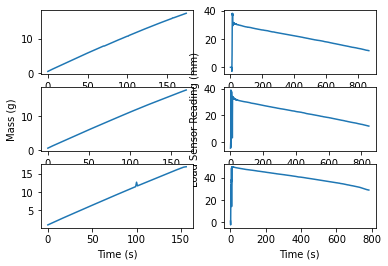

In [48]:
#Read sensor data
fig, axs = plt.subplots(3,2)

#axs[0,0].plot(time_30_light_measured1,csv_data_30_light_measured1)
axs[0,0].plot(csv_data_30_light_measured1)
axs[0,1].plot(time_30_light1, csv_data_30_light1)

#axs[1,0].plot(time_30_light_measured2,csv_data_30_light_measured2)
axs[1,0].plot(csv_data_30_light_measured2)

axs[1,0].set_ylabel('Mass (g)')
axs[1,1].plot(time_30_light2, csv_data_30_light2)
axs[1,1].set_ylabel('Load Sensor Reading (mm)')

#axs[2,0].plot(time_30_light_measured3,csv_data_30_light_measured3)
axs[2,0].plot(csv_data_30_light_measured3)
axs[2,0].set_xlabel('Time (s)')

axs[2,1].plot(time_30_light3, csv_data_30_light3)
axs[2,1].set_xlabel('Time (s)')


In [34]:
csv_data_30_light1

array([ 4.57591818,  5.01692236,  5.89893073, ..., -4.98705253,
       -4.98516969, -4.98148768])

In [49]:
calibration_factor = 1 # 1.2
flow_rate_light1, flow_rate_light1_RAW = get_rolling_slope(csv_data_30_light1, datapnt_delay, calibration_factor)
flow_rate_light2, flow_rate_light2_RAW = get_rolling_slope(csv_data_30_light2, datapnt_delay, calibration_factor)
flow_rate_light3, flow_rate_light3_RAW = get_rolling_slope(csv_data_30_light3, datapnt_delay, calibration_factor)

flow_rate_light_measured1, time_light_measured1_filt = get_rolling_slope_measured(csv_data_30_light_measured1, time_30_light_measured1)
flow_rate_light_measured2, time_light_measured2_filt = get_rolling_slope_measured(csv_data_30_light_measured2, time_30_light_measured2)
flow_rate_light_measured3, time_light_measured3_filt = get_rolling_slope_measured(csv_data_30_light_measured3, time_30_light_measured3)

first_run = True

(0.0, 2.0)

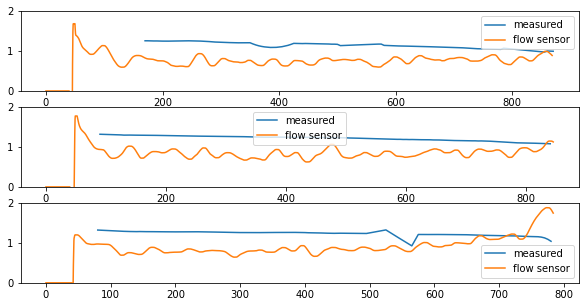

In [50]:
# # ============================================================================
# if first_run:
#     # adjust signal lengths
    
#     time_light_measured1_filt = time_light_measured1_filt[:-10]
#     flow_rate_light_measured1 = flow_rate_light_measured1[:-10]
#     time_30_light1 = time_30_light1[89:-20]
#     flow_rate_light1 = flow_rate_light1[89:-20]
# #     time_light_measured2_filt = time_light_measured2_filt[34:-1]
# #     flow_rate_light_measured2 = flow_rate_light_measured2[34:-1]
#     time_30_light2 = time_30_light2[89:-67]
#     flow_rate_light2 = flow_rate_light2[89:-67]
#     first_run = False
    
# load_scaling_factor = -0.0067
load_scaling_factor = 0.58
#load_scaling_factor = 0.58
flow_rate_light1_scaled = [val*load_scaling_factor for val in flow_rate_light1]
flow_rate_light2_scaled = [val*load_scaling_factor for val in flow_rate_light2]
flow_rate_light3_scaled = [val*load_scaling_factor for val in flow_rate_light3]
# flow_rate_light1_scaled = flow_rate_light1
# flow_rate_light2_scaled = flow_rate_light2
# # =============================================================================

fig, axs_2 = plt.subplots(3)
# fig, axs_2 = plt.subplots(2)
fig.set_figheight(5)
fig.set_figwidth(10)

y_lim = [0,2]
axs_2[0].plot(time_light_measured1_filt, flow_rate_light_measured1, label='measured')
axs_2[0].plot(time_30_light1, flow_rate_light1_scaled, label='flow sensor')
# axs_2[0].plot(time_30_light1, flow_rate_light1, label='flow sensor')
axs_2[0].legend()
axs_2[0].set_ylim(y_lim)

axs_2[1].plot(time_light_measured2_filt, flow_rate_light_measured2, label='measured')
axs_2[1].plot(time_30_light2, flow_rate_light2_scaled, label='flow sensor')
# axs_2[1].plot(time_30_light2, flow_rate_light2, label='flow sensor')
axs_2[1].legend()
axs_2[1].set_ylim(y_lim)

axs_2[2].plot(time_light_measured3_filt, flow_rate_light_measured3, label='measured')
axs_2[2].plot(time_30_light3, flow_rate_light3_scaled, label='flow sensor')
# axs_2[2].plot(time_30_light3, flow_rate_light3, label='flow sensor')
axs_2[2].legend()
axs_2[2].set_ylim(y_lim)

In [44]:
len(time_30_light1)

12963

In [45]:
print('starts')
print(time_light_measured1_filt[0])
print(time_30_light1[89])
print(time_light_measured2_filt[0])
print(time_30_light2[89]) # 2500])

print('ends')
print(time_light_measured1_filt[-10])
print(time_30_light1[-20])
print(time_light_measured2_filt[-8])
print(time_30_light2[-67])

# time_light_measured1_filt = time_light_measured1_filt[:224]
# flow_rate_light_measured1 = flow_rate_light_measured1[:224]
# time_30_light1 = time_30_light1[4400:16501]
# flow_rate_light1 = flow_rate_light1[4400:16501]
# time_light_measured2_filt = time_light_measured2_filt
# flow_rate_light_measured2 = flow_rate_light_measured2
# time_30_light2 = time_30_light2[4500:21601]
# flow_rate_light2 = flow_rate_light2[4500:21601]

starts
460
8.01
360
8.01
ends
1380
1164.87
1385
1403.82


In [46]:
print(np.median(flow_rate_light_measured1))
print(np.median(flow_rate_light1))
print('factor:', np.median(flow_rate_light_measured1) / np.median(flow_rate_light1))

print(np.median(flow_rate_light_measured2))
print(np.median(flow_rate_light2))
print('factor:', np.median(flow_rate_light_measured2) / np.median(flow_rate_light2))


0.5994857142857148
1.2929122342596637
factor: 0.46367084973017303
0.6743142857142852
1.2810634474620113
factor: 0.5263707172741585


In [ ]:
# temp_sig = flow_rate_light1_scaled[5950:-403]
temp_sig = flow_rate_light2_scaled  # [2500:-6]
# temp_sig = csv_data_30_light1 # [1000:12000]
# temp_sig = flow_rate_light2_RAW[50:700]
N = len(temp_sig)
T = datapnt_delay/1000 # time_30_light2[1] - time_30_light2[0]  # 1.0 / 800.0  # difference between x values
print('N=', N, ', T=', T)

# x = np.linspace(0.0, N*T, N, endpoint=False)
# y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)
yf = fft(temp_sig)
xf = fftfreq(N, T)[:N//2]
# import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.subplot(211)
plt.title('flow_rate_light2_RAW[50:700]')
plt.plot(temp_sig, label='signal')
plt.legend()
plt.subplot(212)
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]), label='fft of signal')
plt.legend()
plt.grid()
# plt.ylim([0,10])
plt.xlim([0, 0.01])
plt.show()

In [ ]:
# plt.plot(csv_data_30_light1[1000:12000])
# plt.plot(csv_data_30_light2[1000:17500])
plt.plot(flow_rate_light2_RAW)

In [ ]:
# resample scale/measured data

# ============= FOR DETERMINING LOAD SCALING FACTOR ============= 

for load_scaling_factor in range(50, 70, 1):
# for load_scaling_factor in range(110, 130, 2):
    load_scaling_factor = -load_scaling_factor/10000
    print(load_scaling_factor)
    # ========================
    # GET MSE
    # ========================
    final_measured_1 = resample(flow_rate_light_measured1, len(flow_rate_light1)) # [225:1800]
    final_measured_2 = resample(flow_rate_light_measured2, len(flow_rate_light2)) # [225:1800]
#     final_measured_3 = resample(flow_rate_light_measured3, len(flow_rate_light3)) # [225:1800]
    final_measured_1 = np.around(final_measured_1, decimals=2)
    final_measured_2 = np.around(final_measured_2, decimals=2)
#     final_measured_3 = np.around(final_measured_3, decimals=2)

    final_sensor_1 = [val*load_scaling_factor for val in flow_rate_light1]  #[225:1800]
    final_sensor_2 = [val*load_scaling_factor for val in flow_rate_light2]  #[225:1800]
#     final_sensor_3 = [val*load_scaling_factor for val in flow_rate_light3]  #[225:1800]
#     final_sensor_1 = flow_rate_light1[225:1800]
#     final_sensor_2 = flow_rate_light2[225:1800]
#     final_sensor_3 = flow_rate_light3[225:1800]
    # print(flow_rate_light1)
    final_sensor_1 = np.around(final_sensor_1, decimals=2)
    final_sensor_2 = np.around(final_sensor_2, decimals=2)
#     final_sensor_3 = np.around(final_sensor_3, decimals=2)

    # calculate MSE
    mse_ls = []
    mse_ls.append(mean_squared_error(final_measured_1, final_sensor_1))
    mse_ls.append(mean_squared_error(final_measured_2, final_sensor_2))
#     mse_ls.append(mean_squared_error(final_measured_3, final_sensor_3))

#     print(f'MSE values: {mse1}, {mse3}')
    print(f'Average MSE: {np.mean(mse_ls)}')
    
    max_diff_ls = []
    max_diff_ls.append(max(abs(final_measured_1-final_sensor_1)))
    max_diff_ls.append(max(abs(final_measured_2-final_sensor_2)))
#     max_diff_ls.append(max(abs(final_measured_3-final_sensor_3)))

#     print(f'Max diff: {max_diff_ls}')
    
#     print(f'MSE values: {mse1}, {mse2}, {mse3}')
#     print(f'Average MSE: {np.mean([mse1, mse2, mse3])}')
#     max_diff_1 = max(abs(final_measured_1-final_sensor_1))
#     max_diff_2 = max(abs(final_measured_2-final_sensor_2))
#     max_diff_3 = max(abs(final_measured_3-final_sensor_3))

#     print(f'Max diff: {max_diff_1}, {max_diff_2}, {max_diff_3}')


In [ ]:
# resample scale/measured data


# load_scaling_factor = load_scaling_factor/100
print(calibration_factor)
# ========================
# GET MSE
# ========================
final_measured_1 = resample(flow_rate_light_measured1, len(flow_rate_light1)) # [225:1800]
final_measured_2 = resample(flow_rate_light_measured2, len(flow_rate_light2)) # [225:1800]
# final_measured_3 = resample(flow_rate_light_measured3, len(flow_rate_light3)) # [225:1800]

final_measured_1 = np.around(final_measured_1, decimals=2)
final_measured_2 = np.around(final_measured_2, decimals=2)
# final_measured_3 = np.around(final_measured_3, decimals=2)


# final_sensor_1 = [val*load_scaling_factor for val in flow_rate_light1]  #[225:1800]
# final_sensor_2 = [val*load_scaling_factor for val in flow_rate_light2]  #[225:1800]
# final_sensor_3 = [val*load_scaling_factor for val in flow_rate_light3]  #[225:1800]
final_sensor_1 = flow_rate_light1
final_sensor_2 = flow_rate_light2
# final_sensor_3 = flow_rate_light3

final_sensor_1 = np.around(final_sensor_1, decimals=2)
final_sensor_2 = np.around(final_sensor_2, decimals=2)
# final_sensor_3 = np.around(final_sensor_3, decimals=2)



# calculate MSE
mse_ls = []
mse_ls.append(mean_squared_error(final_measured_1, final_sensor_1))
mse_ls.append(mean_squared_error(final_measured_2, final_sensor_2))
# mse_ls.append(mean_squared_error(final_measured_3, final_sensor_3))
print(f'Average MSE: {np.mean(mse_ls)}')

max_diff_ls = []
max_diff_ls.append(max(abs(final_measured_1-final_sensor_1)))
max_diff_ls.append(max(abs(final_measured_2-final_sensor_2)))
# max_diff_ls.append(max(abs(final_measured_3-final_sensor_3)))

print(f'Max diff: {max_diff_ls}')

#     print(f'MSE values: {mse1}, {mse2}, {mse3}')
#     print(f'Average MSE: {np.mean([mse1, mse2, mse3])}')
#     max_diff_1 = max(abs(final_measured_1-final_sensor_1))
#     max_diff_2 = max(abs(final_measured_2-final_sensor_2))
#     max_diff_3 = max(abs(final_measured_3-final_sensor_3))

#     print(f'Max diff: {max_diff_1}, {max_diff_2}, {max_diff_3}')


In [ ]:
# y_lim = [0,2]
y_lim = [0.5, 1.5]

plt.figure(figsize=(8, 5))
plt.subplot(211)
plt.plot(final_measured_1, label='measured (scale)')
plt.plot(final_sensor_1, label='load sensor')
plt.ylim(y_lim)
plt.legend()
plt.grid()
plt.title(csv_name_30_light1)

plt.subplot(212)
plt.plot(final_measured_2, label='measured (scale)')
plt.plot(final_sensor_2, label='load sensor')
plt.ylim(y_lim)
plt.legend()
plt.grid()
plt.title(csv_name_30_light2)

# plt.subplot(313)
# plt.plot(final_measured_3, label='measured (scale)')
# plt.plot(final_sensor_3, label='load sensor')
# plt.ylim(y_lim)
# # plt.xlabel('Time (s)')
# plt.legend()
# plt.grid()
# plt.title(csv_name_30_light3)

plt.tight_layout()
plt.show()

In [ ]:
# y_lim = [0,3]
# axs_2.plot(time_30_light1,np.multiply(flow_rate_light1,3), label='load sensor')
# axs_2.set_ylim(y_lim)
# axs_2.legend()

In [ ]:
# #Get current sensor stuff
# curr_window_raw = csv_data_30_light1[2000:9000]
# window_width_raw = 50
# window_width_flowrate = 10
# cutoff_1 = 0.09
# order_1 = 1 # 12
# datapnt_delay = 90
# fps = 1000/datapnt_delay
# curr_window_raw_filtered = butter_filter(curr_window_raw, cutoff_1, order_1, fps)
# x =list(range(len(curr_window_raw_filtered)))
# curr_slope, intercept, r, p, std_err = stats.linregress(x, curr_window_raw_filtered)
# fig, axs_3 = plt.subplots(1)
# axs_3.plot(curr_window_raw)
# axs_3.plot(curr_window_raw_filtered)